## Assignment 1

### 1. Letters, words, sentences

In [1]:
import spacy
import nltk
from nltk.corpus import PlaintextCorpusReader
import numpy as np

In [2]:
nlp = spacy.load('en')

In [3]:
import os
docs = np.array([])
doc_list = np.array(os.listdir("cases"))

# We pick n cases at random
n = 300
doc_names = np.random.choice(doc_list, n, replace=False)
cases = [doc_name[5:-4] for doc_name in doc_names]

import pandas as pd
df = pd.DataFrame(doc_names, columns = ['doc_name'])

#
def run_spacy(doc_name):
    file = open("cases/" + doc_name, "r", encoding="utf-8")
    text = file.read()
    file.close()
    return pd.Series([doc_name[5:-4], int(doc_name[:4]), text, nlp(text)], index=['case', 'year', 'text', 'doc'])

df[['case', 'year', 'text', 'doc']] = df.apply(lambda row: run_spacy(row['doc_name']), axis=1)

In [4]:
from matplotlib import pyplot as plt

character_count = [len(list(row['doc'].text)) for index, row in df.iterrows()]
plt.hist(character_count);
plt.xlabel('#characters');
plt.ylabel('#documents');

Text(0, 0.5, '#documents')

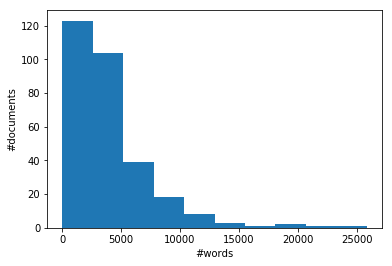

In [5]:
word_count = [len(list(row['doc'])) for index, row in df.iterrows()]
plt.hist(word_count, label='number of words');
plt.xlabel('#words')
plt.ylabel('#documents')

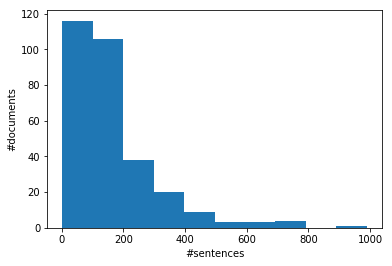

In [6]:
sentence_count = [len(list(row['doc'].sents)) for index, row in df.iterrows()]
plt.hist(sentence_count, label='number of sentences');
plt.xlabel('#sentences');
plt.ylabel('#documents');

### 2. Nouns, verbs, adjectives

In [7]:
from spacy.symbols import NOUN, VERB, ADJ

# Count frequency of POS in document
def get_frequency(doc, pos):
    n_pos = 0;
    n_tokens = 0;
    for token in doc:
        n_tokens += 1
        if token.pos == pos:
            n_pos += 1;
    return n_pos/n_tokens;

def get_frequencies(doc):
    return pd.Series([get_frequency(doc, NOUN), get_frequency(doc, VERB), get_frequency(doc, ADJ)], index=['N', 'V', 'J'])

In [8]:
df[['N', 'V', 'J']] = df.apply(lambda row: get_frequencies(row['doc']), axis=1)

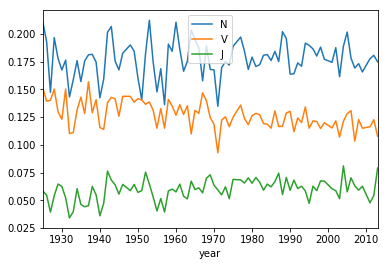

In [9]:
df[['year','N','V','J']].groupby('year').mean().plot();

### 3. Normalize the corpus

In [10]:
from string import punctuation
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

# Input spacy document and return list of normalized tokens while retaining the tags
def normalize_tokens(doc):
    tokens = []
    for token in doc:
        text = token.text
        text = text.lower() # all lower case       
        if text in punctuation + '\r\n ' or text == '': # no punctuation, empty strings, space
            continue
        if text in stoplist: # no words in stop list
            continue
        if text.isdigit(): # digits
            text = '#'
        text = stemmer.stem(text) # stem each word
        tokens.append((text, token.tag_)) # add to list of tokens for this case
    return tokens
        
df['normalized_tokens'] = df['doc'].apply(normalize_tokens)

In [11]:
def trigrams(tokens):
    return [tokens[i-2][0] + "_" + tokens[i-1][0] 
            + "_" + tokens[i][0] for i in range(2, len(tokens)) if tokens[i][1].startswith("N")]

In [12]:
df['trigrams'] = df['normalized_tokens'].apply(trigrams)

### 4. Select features

In [13]:
feature_set = set()
for trigrams in df['trigrams']:
    feature_set.update(trigrams)

# calculate tf-idf-frequencies, then select the top 1000 trigrams for our feature set
from collections import Counter
trigram_count = Counter()
document_count = Counter()
total_count = 0

for row in df['trigrams']:
    trigram_count.update(row)
    total_count += len(row)
    document_count.update(set(row))

# select as features the 1000 trigrams with highest tf-idf-score (tf over all the documents, #documents = n)
# among the trigrams which appear in more than one document and fewer than half

In [14]:
import math

scores = {}
for trigram, count in trigram_count.most_common():
    if document_count[trigram] == 1 or document_count[trigram] > n/2:
        continue
    else:
        scores[trigram] = count / total_count * math.log(n / document_count[trigram])

In [15]:
import operator
best_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)[:1000]
features = [feature for (feature, score) in best_scores]

# Make a cloud of the highest scored trigrams

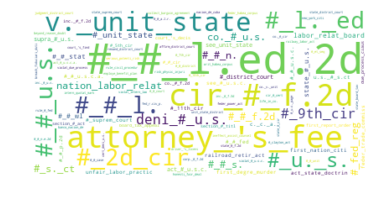

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# generate word cloud of words with highest counts
poscloud = WordCloud(background_color='white').generate_from_frequencies(scores) 

plt.imshow(poscloud, interpolation='bilinear') 
plt.axis("off") 
plt.show()

#### Determine feature frequencies

In [17]:
# Determine feature frequencies

feature_counter = Counter()
feature_df = pd.DataFrame(index=cases, columns=features)

for index, row in df.iterrows():
    feature_counter.clear()
    feature_counter.update(row['trigrams']) 
    feature_df.loc[row['case']]=feature_counter # for some reason this inserts NaNs rather than 0...
    
feature_df.fillna(0, inplace=True) # so turn the NaNs into 0
    
# Standardize to variance 1

from sklearn import preprocessing
# Create the Scaler object
scaler = preprocessing.StandardScaler(with_mean=False) # only variance
standardized_arr = scaler.fit_transform(feature_df) # transform and get numpy-array
standardized_df = pd.DataFrame(standardized_arr, index=cases, columns=features)

In [18]:
reversed_df = pd.read_csv('case_reversed.csv', index_col='caseid')
new_df = standardized_df.join(reversed_df) # add the

### Logistic Regression model

In [19]:
from sklearn.linear_model import LogisticRegression

# Training and test set

from sklearn.model_selection import train_test_split

train, test = train_test_split(new_df, test_size=0.3) # Pick 70% for training, rest for testing

logit = LogisticRegression(solver='liblinear')
logit.fit(train[features], train['case_reversed'])



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [20]:
accuracy_train = logit.score(train[features], train['case_reversed'])
accuracy_test = logit.score(test[features], test['case_reversed'])

train_predict = logit.predict(train[features])
test_predict = logit.predict(test[features])

from sklearn.metrics import f1_score
f1_train = f1_score(train['case_reversed'], train_predict)
f1_test = f1_score(test['case_reversed'], test_predict)

print('Accuracy for training set: ', accuracy_train)
print('F1 for training set: ', f1_train)
print('Accuracy for test set: ', accuracy_test)
print('F1 for test set: ', f1_test)

Accuracy for training set:  0.9904761904761905
F1 for training set:  0.9929577464788732
Accuracy for test set:  0.5444444444444444
F1 for test set:  0.6821705426356589


In [21]:
# Use grid search to find best hyper-parameters for the model

from sklearn.model_selection import GridSearchCV
params = {'C': [.1,1,10,100], 'penalty': ['l1','l2']}
grid = GridSearchCV(logit,params,n_jobs=-1,cv=5,iid=False)
grid.fit(train[features], train['case_reversed']);

In [22]:
print('Best hyper-parameters: ', grid.best_params_)

Best hyper-parameters:  {'C': 0.1, 'penalty': 'l1'}


In [23]:
logit_best = grid.best_estimator_

In [24]:
accuracy_train_best = logit_best.score(train[features], train['case_reversed'])
accuracy_test_best = logit_best.score(test[features], test['case_reversed'])

train_predict_best = logit_best.predict(train[features])
test_predict_best = logit_best.predict(test[features])

f1_train_best = f1_score(train['case_reversed'], train_predict_best)
f1_test_best = f1_score(test['case_reversed'], test_predict_best)

print('Best accuracy for training set: ', accuracy_train_best)
print('Best F1 for training set: ', f1_train_best)
print('Best accuracy for test set: ', accuracy_test_best)
print('Best F1 for test set: ', f1_test_best)

Best accuracy for training set:  0.8142857142857143
Best F1 for training set:  0.8785046728971964
Best accuracy for test set:  0.6555555555555556
Best F1 for test set:  0.786206896551724


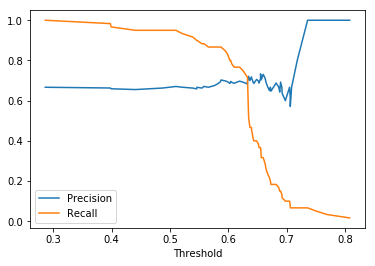

In [25]:
from sklearn.metrics import precision_recall_curve

test_predict_proba_best = logit_best.predict_proba(test[features]) # Get probabilities that 0/1
metrics = precision_recall_curve(test['case_reversed'],test_predict_proba_best[:,1])
precisions, recalls, thresholds = metrics
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel('Threshold')
plt.legend()
plt.show()

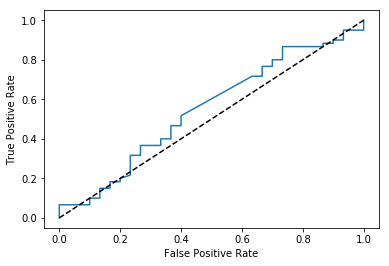

In [26]:
# AUC

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(test['case_reversed'], test_predict_proba_best[:,1])
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### 7. Sentiment analysis

In [27]:
# New data frame with sentences

sentences = []
for index, row in df.iterrows():
    i = 0
    for sent in row['doc'].sents:
        sentences.append(sent.text)

df_sent = pd.DataFrame(data=sentences, columns=['text'])

In [28]:
# Perform sentiment analysis 

from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

def get_score(text):
    return analyser.polarity_scores(text)['compound']
    
df_sent[['score']] = df_sent.apply(lambda row: pd.Series(get_score(row['text']), index=['score']), axis=1)


C:\ProgramData\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [29]:
# Report 10 sentences with largest/smallest scores

df_highest = df_sent.nlargest(10, 'score')['text']
df_lowest = df_sent.nsmallest(10, 'score')['text']

print("Sentences with highest sentiment score:\n")

for sentence in df_highest.values:
    print(sentence)
    
print("Sentences with lowest sentiment score:\n")

for sentence in df_lowest.values:
    print(sentence)

Sentences with highest sentiment score:

But see, Gendron v. United States , 295 F.2d 897 (8 Cir. 1961); Johnson v. United States , 291 F.2d 150 (8 Cir. 1961); Rizzo v. United States , 295 F.2d 638 (8 Cir. 1961); Wegman v. United States , 272 F.2d 31 (8 Cir. 1959); Rosenbloom v. United States , 259 F.2d 500 (8 Cir. 1958) cert.
In Part V of the plurality opinion, written by Justice Stewart for himself, Justice Blackmun and Justice Powell, and concurred in by Justice Brennan for himself, Justice Douglas and Justice Marshall 11 over sharp dissents by Chief Justice Burger and Justice Rehnquist, the latter being joined by Justice White, the Court held unconstitutional a Pennsylvania statute, Act 194, which authorized the Secretary of Education to provide "auxiliary services" to all children enrolled in nonpublic elementary and secondary schools meeting Pennsylvania's compulsory attendance requirements.

He discussed in the conferences the then present and future needs of his daughter and he


The Guidelines definition of crime of violence appears in USSG 4B1.2 (a): The term "crime of violence" means any offense under federal or state law, punishable by imprisonment for a term exceeding one year, that — (1) has as an element the use, attempted use, or threatened use of physical force against the person of another, or (2) is burglary of a dwelling, arson, or extortion, involves use of explosives, or otherwise involves conduct that presents a serious potential risk of physical injury to another.

The relevant portion of the ACCA definition of violent felony is: any crime punishable by imprisonment for a term exceeding one year , or any act of juvenile delinquency involving the use or carrying of a firearm, knife, or destructive device that would be punishable by imprisonment for such term if committed by an adult, that — (I) has as an element the use, attempted use, or threatened use of physical force against the person of another; or (ii) is burglary, arson, or extortion, in

### 8. Similarities between sentences

In [30]:
# tf-idf extraction 

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=0.001, # at min .1% of docs
                        max_df=0.5,  # at most 50% of docs
                        max_features=1000,
                        stop_words='english',
                        use_idf=True,
                        ngram_range=(2,3))

X = tfidf.fit_transform(df_sent['text']) # Tf-idf-weighted sentence-feature matrix

In [31]:
from sklearn.metrics.pairwise import cosine_similarity

Y = cosine_similarity(X)

# for max similarity set diagonal = 0 -> not interested in similarity with itself
np.fill_diagonal(Y,0)
# Best matching sentences
indices_best_match = np.unravel_index(Y.argmax(), Y.shape)


MemoryError: 

In [ ]:
# With match
Y[indices_best_match]

In [ ]:
df_sent.loc[indices_best_match[0], 'text']

In [ ]:
df_sent.loc[indices_best_match[1], 'text']

In [ ]:
# Worst match anything with entry 0
Y[0,1]

In [ ]:
df_sent.loc[0, 'text']

In [ ]:
df_sent.loc[1, 'text']

### 9. k-means clustering

In [ ]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=20, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

In [ ]:
sentence_clusters = model.labels_.tolist()
df_sent['cluster'] = sentence_clusters

In [ ]:
# Print 5 sentences from each of the 20 clusters:

for i in range(20):
    print('\nCluster ', i)
    print
    print(df_sent[df_sent['cluster']==i]['text'][:5])